In [56]:
import geopandas as gpd 
import pandas as pd 
training_data = gpd.read_file('../results/agri_points_with_labels.geojson')

In [57]:
training_data.columns

Index(['Latitude', 'Longitude', 'boron', 'nitrogen', 'phos', 'potas', 'pH',
       'zinc', 'clay', 'OM', 'Sand', 'Silt', 'Rainfall', 'Temp', 'Elevation',
       'Slope', 'nearest_rainfall', 'Water', 'Road', 'LULC_Code', 'class',
       'class_level_1', 'class_level_2', 'geometry'],
      dtype='object')

In [58]:
features = ['Latitude', 'Longitude', 'boron', 'nitrogen', 'phos', 'potas', 'pH',
            'zinc', 'clay', 'OM', 'Sand', 'Silt', 'Rainfall', 'Temp', 'Elevation',
            'Slope', 'nearest_rainfall', 'Water', 'Road', 'LULC_Code']

In [59]:
target = 'class_level_1'

In [60]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np 
import matplotlib.pyplot as plt

training_data_clean = training_data.dropna(subset=[target])

X = training_data_clean[features].values
y = training_data_clean[target].values
labels = training_data_clean[target].unique()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=5, stratify=y
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
print(f"\nTrain distribution:\n{pd.Series(y_train).value_counts()}")
print(f"\nTest distribution:\n{pd.Series(y_test).value_counts()}")

Train size: 2765, Test size: 692

Train distribution:
not_suitable            1701
low_suitability          576
high_suitability         404
moderate_suitability      84
Name: count, dtype: int64

Test distribution:
not_suitable            426
low_suitability         144
high_suitability        101
moderate_suitability     21
Name: count, dtype: int64


In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def train_classifier(clf, param_grid, X_train, y_train, X_test, y_test, model_name, model_type='rf'):
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', clf)
    ])
    param_grid = {f'classifier__{key}': value for key, value in param_grid.items()}
    
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=5, 
        scoring='f1_macro', 
        n_jobs=-1, 
        verbose=1,
        return_train_score=True,
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"\nBest hyper param: {grid_search.best_params_}")
    print(f"Training F1-macro score: {grid_search.cv_results_['mean_train_score'][grid_search.best_index_]:.4f}")
    print(f"Validation F1-macro score: {grid_search.cv_results_['mean_test_score'][grid_search.best_index_]:.4f}")
    
    best_params = grid_search.best_params_
    best_params_clean = {key.replace('classifier__', ''): value for key, value in best_params.items()}
    
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', clf.__class__(**best_params_clean))
    ])
    
    best_model = model.fit(X_train, y_train)
    
    y_pred = best_model.predict(X_test)
    
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    print(f"Test F1-macro score: {f1_macro:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay(cm, display_labels=labels).plot(ax=ax, cmap=plt.cm.Blues, 
                                                                colorbar=False, xticks_rotation=90)
    ax.set_title(f'{model_name} Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    if model_type == 'rf':
        mdi_importances = pd.Series(
            best_model.named_steps['classifier'].feature_importances_, index=features
        ).sort_values(ascending=True)
        
        ax = mdi_importances.plot.barh()
        ax.set_title(f"{model_name} Feature Importances (MDI)")
        ax.figure.tight_layout()
    
    return best_model, best_params

Train random forest 

Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best hyper param: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 200}
Training F1-macro score: 0.9543
Validation F1-macro score: 0.6330
Test F1-macro score: 0.6849

Classification Report:
                      precision    recall  f1-score   support

    high_suitability       0.51      0.56      0.54       101
     low_suitability       0.95      0.94      0.95       144
moderate_suitability       0.47      0.33      0.39        21
        not_suitable       0.87      0.86      0.87       426

            accuracy                           0.82       692
           macro avg       0.70      0.68      0.68       692
        weighted avg       0.82      0.82      0.82       692



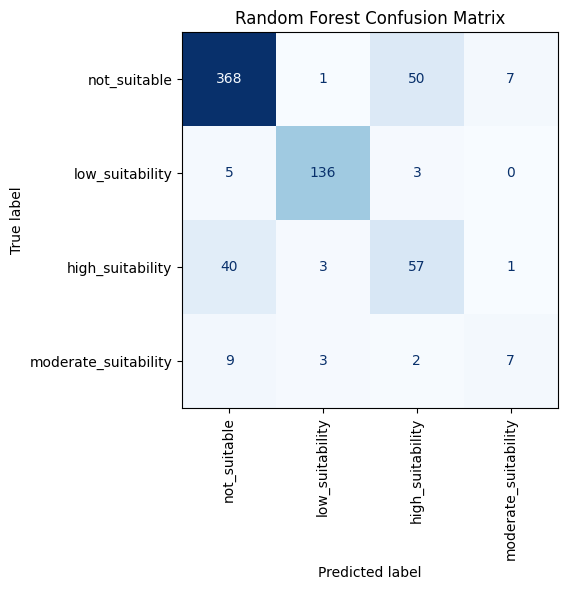

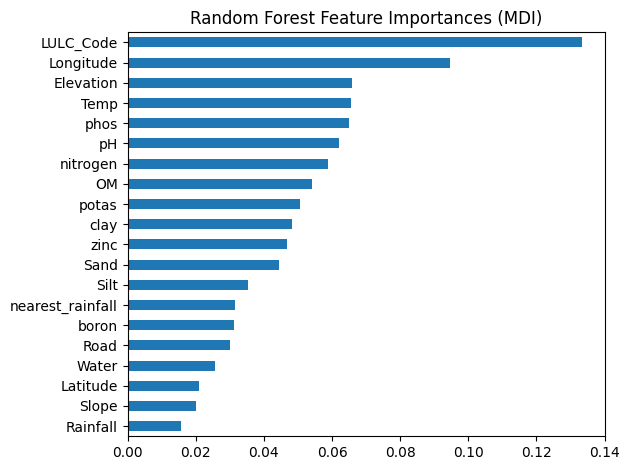

In [62]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    # 'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    # 'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

rf_clf = RandomForestClassifier(random_state=5)

rf_model, rf_best_params = train_classifier(
    rf_clf, 
    rf_param_grid, 
    X_train, y_train, 
    X_test, y_test, 
    model_name='Random Forest',
    model_type='rf'
)


Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best hyper param: {'classifier__C': 10, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
Training F1-macro score: 0.8122
Validation F1-macro score: 0.6017
Test F1-macro score: 0.6212

Classification Report:
                      precision    recall  f1-score   support

    high_suitability       0.66      0.42      0.51       101
     low_suitability       0.93      0.95      0.94       144
moderate_suitability       0.29      0.10      0.14        21
        not_suitable       0.85      0.94      0.89       426

            accuracy                           0.84       692
           macro avg       0.68      0.60      0.62       692
        weighted avg       0.82      0.84      0.82       692



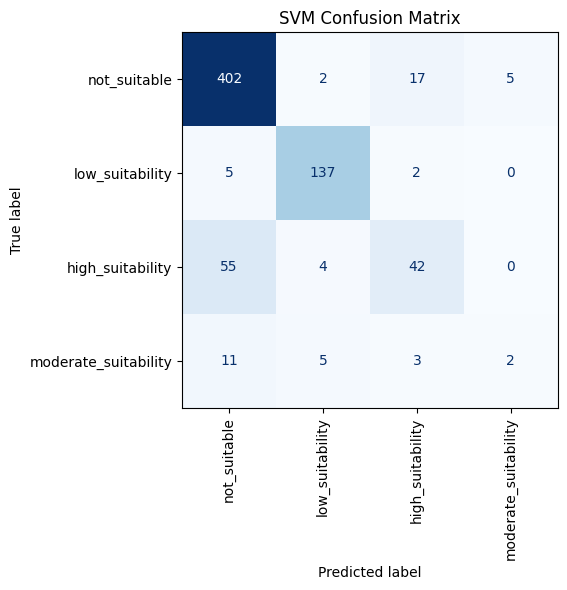

In [63]:
svm_param_grid = {
    'C': [0.1, 1, 10, 100, 200],
    # 'gamma' : ['scale', 'auto'],
    'gamma': ['scale', 'auto', 0.01, 0.1, 0.3],
    # 'kernel': ['rbf', 'poly', 'sigmoid']
    'kernel': ['rbf','sigmoid']
    
}

svm_clf = SVC(random_state=5)


svm_model, svm_best_params = train_classifier(
    svm_clf, 
    svm_param_grid, 
    X_train, y_train, 
    X_test, y_test, 
    "SVM",
    model_type='svm'
)